### RQ1: Cross-Domain Transfer Learning for Pathological Motion Recognition.
RQ1: Cross-Domain Transfer Learning for Pathological Motion Recognition. It builds on your UCI HAR baseline, adds self-supervised pretraining (SimCLR), and supports two domain-adaptation options:

- DANN (adversarial domain alignment)

- Contrastive alignment between source (healthy) and target (pathological) embeddings (class-prototype contrast + optional CORAL)

It also includes a tiny synthetic pathological generator (more realistic tonic–clonic & absence) so you can test end-to-end immediately.

In [1]:
# ---- Core ----
import os, math, random
import numpy as np
import matplotlib.pyplot as plt

# ---- PyTorch ----
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ---- Metrics ----
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# ---- Repro/Device ----
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def device_autoselect():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    return device

def ensure_dir(path): os.makedirs(path, exist_ok=True)

set_seed(42)
device = device_autoselect()
ensure_dir("runs")


Using device: cuda


### Dataset

In [2]:
class UCIHARDataset(Dataset):
    """
    Loader for UCI-HAR-style folders (also works for EpilepsyHAR_Realistic).
    Returns x:[T,C] (float32), y:int label (0-based).
    """
    def __init__(self, root: str, split: str = "train", use_inertial=True):
        assert split in ["train","test"]
        inertial_dir = os.path.join(root, split, "Inertial Signals")
        self.use_inertial = use_inertial and os.path.isdir(inertial_dir)
        y_path = os.path.join(root, split, f"y_{split}.txt")
        self.labels = np.loadtxt(y_path).astype(int).ravel()
        if self.labels.min() == 1:  # shift 1..K -> 0..K-1 if needed
            self.labels = self.labels - 1

        if self.use_inertial:
            sigs = [
                "total_acc_x_","total_acc_y_","total_acc_z_",
                "body_acc_x_","body_acc_y_","body_acc_z_",
                "body_gyro_x_","body_gyro_y_","body_gyro_z_",
            ]
            arrays = [np.loadtxt(os.path.join(inertial_dir, s+split+".txt")) for s in sigs]
            self.data = np.stack(arrays, axis=-1).astype(np.float32)  # [N,T,9]
        else:
            X_path = os.path.join(root, split, f"X_{split}.txt")      # 561-D features fallback
            X = np.loadtxt(X_path).astype(np.float32)
            self.data = X[:,:,None]                                   # [N,561,1]
        assert len(self.data) == len(self.labels)

    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)  # [T,C]
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y


class TimeSeriesTransform:
    """Channel-wise normalization + optional augmentations for SSL."""
    def __init__(self, normalize=True, augment=False):
        self.normalize = normalize
        self.augment = augment
        self.mean = None; self.std = None

    def fit(self, data_array):  # [N,T,C]
        flat = data_array.reshape(-1, data_array.shape[-1])
        self.mean = flat.mean(axis=0); self.std = flat.std(axis=0) + 1e-8

    def __call__(self, x):
        if isinstance(x, torch.Tensor): x = x.numpy()
        if self.normalize and self.mean is not None:
            x = (x - self.mean) / self.std
        if self.augment:
            x = self._augment(x)
        return torch.tensor(x, dtype=torch.float32)

    def _augment(self, x):
        T,C = x.shape
        # jitter
        if random.random()<0.9: x += np.random.normal(0,0.02,size=x.shape)
        # scaling
        if random.random()<0.8: x *= np.random.normal(1.0,0.1,size=(1,C))
        # time mask
        if random.random()<0.5:
            m = int(T*0.1); s = random.randint(0, max(0,T-m-1)); x[s:s+m] = 0
        # crop + pad back
        if random.random()<0.7:
            keep = int(T*0.9); s = random.randint(0, T-keep)
            x = np.pad(x[s:s+keep], ((0,T-keep),(0,0)))
        # segment permutation
        if random.random()<0.3:
            segs = np.array_split(x, 4, axis=0); random.shuffle(segs); x = np.concatenate(segs, axis=0)
        return x


class SimCLRDataset(Dataset):
    """Wrap base dataset to produce two augmented views."""
    def __init__(self, base: Dataset, transform: TimeSeriesTransform):
        self.base = base; self.transform = transform
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        x,y = self.base[idx]
        return self.transform(x), self.transform(x), y


### Cell 3 — Models & Losses & Evaluation

In [3]:
# ------------ Encoder ------------
class Encoder1D(nn.Module):
    """CNN backbone; optional BiLSTM head; outputs L2-normalized embedding."""
    def __init__(self, in_channels=9, emb_dim=256, hidden=128, use_lstm=False, lstm_hidden=128):
        super().__init__()
        self.use_lstm = use_lstm
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels,64,7,padding=3), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64,128,5,padding=2), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Conv1d(128,hidden,3,padding=1),    nn.BatchNorm1d(hidden), nn.ReLU(),
            nn.AdaptiveAvgPool1d(32)
        )
        if use_lstm:
            self.lstm = nn.LSTM(hidden, lstm_hidden, batch_first=True, bidirectional=True)
            proj_in = lstm_hidden*2
        else:
            proj_in = hidden*32
        self.proj = nn.Linear(proj_in, emb_dim)

    def forward(self, x):        # x: [B,T,C]
        x = x.transpose(1,2)     # [B,C,T]
        h = self.conv(x)
        if self.use_lstm:
            h = h.transpose(1,2) # [B,T',H]
            h,_ = self.lstm(h)
            h = h.mean(dim=1)
        else:
            h = h.flatten(1)
        z = F.normalize(self.proj(h), dim=-1)
        return z

# ------------ Heads ------------
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=256, proj_dim=128):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_dim,in_dim), nn.ReLU(), nn.Linear(in_dim,proj_dim))
    def forward(self, x): return F.normalize(self.net(x), dim=-1)

class ClassifierHead(nn.Module):
    def __init__(self, in_dim=256, n_classes=6):
        super().__init__()
        self.fc = nn.Linear(in_dim, n_classes)
    def forward(self, x): return self.fc(x)

# ------------ Losses ------------
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.2): super().__init__(); self.t = temperature
    def forward(self, z1, z2):
        B = z1.size(0)
        z = torch.cat([z1,z2], dim=0)          # [2B,D]
        sim = torch.mm(z, z.t()) / self.t
        mask = torch.eye(2*B, dtype=torch.bool, device=z.device)
        sim.masked_fill_(mask, -9e15)
        labels = torch.cat([torch.arange(B,2*B), torch.arange(0,B)], dim=0).to(z.device)
        return F.cross_entropy(sim, labels)

def coral_loss(source, target):
    def cov(feat):
        xm = feat - feat.mean(dim=0, keepdim=True)
        return (xm.t() @ xm) / (feat.size(0)-1)
    cs, ct = cov(source), cov(target)
    return F.mse_loss(cs, ct)

# ------------ DANN helper ------------
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lam): ctx.lam = lam; return x.view_as(x)
    @staticmethod
    def backward(ctx, g): return -ctx.lam*g, None
def grad_reverse(x, lam): return GradReverse.apply(x, lam)

class DomainClassifier(nn.Module):
    def __init__(self, in_dim=256, hidden=128):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_dim,hidden), nn.ReLU(), nn.Linear(hidden,2))
    def forward(self, x, lam=1.0): return self.net(grad_reverse(x, lam))

# ------------ Evaluation ------------
def evaluate(encoder, head, loader, device):
    encoder.eval(); head.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            logits = head(encoder(x))
            y_true.append(y.numpy())
            y_pred.append(logits.argmax(1).cpu().numpy())
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    cm  = confusion_matrix(y_true, y_pred)
    return acc, f1, cm

def domain_confusion_score(encoder, loader_src, loader_tgt, device):
    """Train a small linear domain classifier on frozen embeddings; report accuracy.
       Lower accuracy = better alignment."""
    encoder.eval()
    feats, dom = [], []
    with torch.no_grad():
        for x,_ in loader_src:
            z = encoder(x.to(device)).cpu().numpy(); feats.append(z); dom.append(np.zeros(z.shape[0], int))
        for x,_ in loader_tgt:
            z = encoder(x.to(device)).cpu().numpy(); feats.append(z); dom.append(np.ones(z.shape[0], int))
    X = torch.tensor(np.concatenate(feats), dtype=torch.float32).to(device)
    y = torch.tensor(np.concatenate(dom), dtype=torch.long).to(device)
    clf = nn.Linear(X.size(1), 2).to(device)
    opt = torch.optim.Adam(clf.parameters(), lr=1e-3)
    for _ in range(200):
        loss = F.cross_entropy(clf(X), y)
        opt.zero_grad(); loss.backward(); opt.step()
    with torch.no_grad():
        acc = (clf(X).argmax(1) == y).float().mean().item()
    return acc


### Cell 4 — Self-Supervised Pretraining (SimCLR) — resumable

In [4]:
def pretrain_simclr_notebook(
    uci_root="UCIHARDataset",
    batch_size=256, epochs=10, lr=1e-3, weight_decay=1e-4,
    temperature=0.2, emb_dim=256, proj_dim=128, use_lstm=False,
    ckpt_path="runs/simclr_src_last.pt", seed=42
):
    set_seed(seed); ensure_dir("runs"); dev = device

    # Data (source = UCI HAR train)
    src = UCIHARDataset(uci_root, "train")
    t = TimeSeriesTransform(normalize=True, augment=True); t.fit(src.data)
    loader = DataLoader(SimCLRDataset(src, t), batch_size=batch_size, shuffle=True, drop_last=True)

    in_ch = src[0][0].shape[1]
    encoder = Encoder1D(in_channels=in_ch, emb_dim=emb_dim, use_lstm=use_lstm).to(dev)
    proj    = ProjectionHead(in_dim=emb_dim, proj_dim=proj_dim).to(dev)
    opt     = torch.optim.AdamW(list(encoder.parameters())+list(proj.parameters()), lr=lr, weight_decay=weight_decay)
    crit    = NTXentLoss(temperature=temperature)

    # Resume
    start_epoch, losses = 0, []
    if os.path.exists(ckpt_path):
        cp = torch.load(ckpt_path, map_location=dev)
        encoder.load_state_dict(cp["encoder"], strict=False)
        proj.load_state_dict(cp["proj"], strict=False)
        if "optimizer" in cp: opt.load_state_dict(cp["optimizer"])
        start_epoch = cp.get("epoch", 0)
        losses = cp.get("losses", [])
        print(f"✅ Resuming SimCLR from epoch {start_epoch}")

    # Train
    for ep in range(start_epoch+1, start_epoch+epochs+1):
        encoder.train(); proj.train(); total=0.0
        for v1,v2,_ in loader:
            v1,v2 = v1.to(dev), v2.to(dev)
            p1, p2 = proj(encoder(v1)), proj(encoder(v2))
            loss = crit(p1,p2)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()
        avg = total/len(loader); losses.append(avg)
        print(f"[SimCLR] Epoch {ep}: loss={avg:.4f}")
        torch.save({"epoch":ep,"encoder":encoder.state_dict(),"proj":proj.state_dict(),
                    "optimizer":opt.state_dict(),"losses":losses}, ckpt_path)

    # Plot loss
    plt.figure(figsize=(5,3)); plt.plot(losses, marker='o')
    plt.title("SimCLR Training Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.tight_layout(); plt.show()
    return encoder, proj, losses

# —— Run pretraining (adjust epochs as you like)
# encoder_src, proj_src, _ = pretrain_simclr_notebook(epochs=10, batch_size=256)


/tmp/ipykernel_9275/3224549427.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cp = torch.load(ckpt_path, map_location=dev)


✅ Resuming SimCLR from epoch 100
[SimCLR] Epoch 101: loss=1.8676
[SimCLR] Epoch 102: loss=1.8621
[SimCLR] Epoch 103: loss=1.8606
[SimCLR] Epoch 104: loss=1.8571
[SimCLR] Epoch 105: loss=1.8626
[SimCLR] Epoch 106: loss=1.8566
[SimCLR] Epoch 107: loss=1.8602
[SimCLR] Epoch 108: loss=1.8599
[SimCLR] Epoch 109: loss=1.8581
[SimCLR] Epoch 110: loss=1.8525
[SimCLR] Epoch 111: loss=1.8552
[SimCLR] Epoch 112: loss=1.8572
[SimCLR] Epoch 113: loss=1.8515
[SimCLR] Epoch 114: loss=1.8524
[SimCLR] Epoch 115: loss=1.8526
[SimCLR] Epoch 116: loss=1.8505
[SimCLR] Epoch 117: loss=1.8517
[SimCLR] Epoch 118: loss=1.8538
[SimCLR] Epoch 119: loss=1.8515
[SimCLR] Epoch 120: loss=1.8468
[SimCLR] Epoch 121: loss=1.8503
[SimCLR] Epoch 122: loss=1.8547
[SimCLR] Epoch 123: loss=1.8480
[SimCLR] Epoch 124: loss=1.8449
[SimCLR] Epoch 125: loss=1.8455
[SimCLR] Epoch 126: loss=1.8505
[SimCLR] Epoch 127: loss=1.8476
[SimCLR] Epoch 128: loss=1.8504
[SimCLR] Epoch 129: loss=1.8410
[SimCLR] Epoch 130: loss=1.8442
[SimCLR

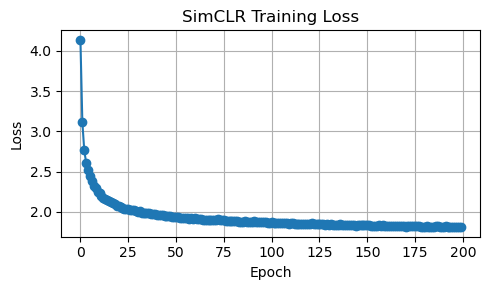

In [5]:
encoder_src, proj_src, _ = pretrain_simclr_notebook(epochs=100, batch_size=256)

### Cell 5 — Transfer: Linear Probe (freeze encoder)

In [6]:
def transfer_linear_notebook(
    uci_root="UCIHARDataset",
    tgt_root="EpilepsyHAR_Realistic",
    ckpt="runs/simclr_src_last.pt",
    batch_size=256, epochs=10, lr=1e-3, emb_dim=256, use_lstm=False, tgt_classes=4
):
    dev = device
    # Normalization from source
    src_tr = UCIHARDataset(uci_root, "train")
    tfm_src = TimeSeriesTransform(normalize=True, augment=False); tfm_src.fit(src_tr.data)

    # Target loaders
    tgt_tr = UCIHARDataset(tgt_root, "train")
    tgt_te = UCIHARDataset(tgt_root, "test")

    class Wrap(Dataset):
        def __init__(self, base, tfm): self.base=base; self.tfm=tfm
        def __len__(self): return len(self.base)
        def __getitem__(self,i): x,y=self.base[i]; return self.tfm(x), y

    tr = DataLoader(Wrap(tgt_tr, tfm_src), batch_size=batch_size, shuffle=True)
    te = DataLoader(Wrap(tgt_te, tfm_src), batch_size=batch_size)

    in_ch = tgt_tr[0][0].shape[1]
    encoder = Encoder1D(in_channels=in_ch, emb_dim=emb_dim, use_lstm=use_lstm).to(dev)
    head    = ClassifierHead(in_dim=emb_dim, n_classes=tgt_classes).to(dev)

    # Load pretrained encoder & freeze
    cp = torch.load(ckpt, map_location=dev); encoder.load_state_dict(cp["encoder"], strict=False)
    for p in encoder.parameters(): p.requires_grad=False

    opt = torch.optim.Adam(head.parameters(), lr=lr)
    for ep in range(1, epochs+1):
        head.train()
        for x,y in tr:
            x,y = x.to(dev), y.to(dev)
            with torch.no_grad(): z = encoder(x)
            loss = F.cross_entropy(head(z), y)
            opt.zero_grad(); loss.backward(); opt.step()
        acc,f1,cm = evaluate(encoder, head, te, dev)
        print(f"[Linear] Epoch {ep}: acc={acc:.4f} f1={f1:.4f}\nCM=\n{cm}")
    return encoder, head

# —— Run linear probe
# enc_lin, head_lin = transfer_linear_notebook(epochs=10)


In [ ]:
enc_lin, head_lin = transfer_linear_notebook(epochs=100)

### Cell 6 — Transfer: Full Fine-Tuning (unfreeze)

In [7]:
def transfer_finetune_notebook(
    uci_root="UCIHARDataset",
    tgt_root="EpilepsyHAR_Realistic",
    ckpt="runs/simclr_src_last.pt",
    batch_size=256, epochs=10, lr=1e-3, weight_decay=1e-4,
    emb_dim=256, use_lstm=False, tgt_classes=4
):
    dev = device
    src_tr = UCIHARDataset(uci_root, "train")
    tfm_src = TimeSeriesTransform(normalize=True, augment=False); tfm_src.fit(src_tr.data)

    tgt_tr = UCIHARDataset(tgt_root, "train"); tgt_te = UCIHARDataset(tgt_root, "test")
    class Wrap(Dataset):
        def __init__(self, base, tfm): self.base=base; self.tfm=tfm
        def __len__(self): return len(self.base)
        def __getitem__(self,i): x,y=self.base[i]; return self.tfm(x), y
    tr = DataLoader(Wrap(tgt_tr, tfm_src), batch_size=batch_size, shuffle=True)
    te = DataLoader(Wrap(tgt_te, tfm_src), batch_size=batch_size)

    in_ch = tgt_tr[0][0].shape[1]
    encoder = Encoder1D(in_channels=in_ch, emb_dim=emb_dim, use_lstm=use_lstm).to(dev)
    head    = ClassifierHead(in_dim=emb_dim, n_classes=tgt_classes).to(dev)

    cp = torch.load(ckpt, map_location=dev); encoder.load_state_dict(cp["encoder"], strict=False)
    opt = torch.optim.AdamW(list(encoder.parameters())+list(head.parameters()), lr=lr, weight_decay=weight_decay)

    for ep in range(1, epochs+1):
        encoder.train(); head.train()
        for x,y in tr:
            x,y = x.to(dev), y.to(dev)
            loss = F.cross_entropy(head(encoder(x)), y)
            opt.zero_grad(); loss.backward(); opt.step()
        acc,f1,cm = evaluate(encoder, head, te, dev)
        print(f"[FineTune] Epoch {ep}: acc={acc:.4f} f1={f1:.4f}\nCM=\n{cm}")
    return encoder, head

# —— Run fine-tuning
# enc_ft, head_ft = transfer_finetune_notebook(epochs=10)


In [ ]:
enc_ft, head_ft = transfer_finetune_notebook(epochs=100)

### Cell 7 — DANN (Adversarial Domain Alignment)

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [8]:
def dann_notebook_debug(
    uci_root="UCIHARDataset",
    tgt_root="EpilepsyHAR_Realistic",
    ckpt="runs/simclr_src_last.pt",
    batch_size=256,
    epochs=20,
    lr=1e-3,
    emb_dim=256,
    use_lstm=False,
    lambda_dom=0.5,
    seed=42
):
    import math, random
    set_seed(seed)
    dev = device_autoselect()

    # ---------------- Load datasets ----------------
    src_tr = UCIHARDataset(uci_root, "train")
    tgt_tr = UCIHARDataset(tgt_root, "train")
    tgt_te = UCIHARDataset(tgt_root, "test")

    # Force 0-based int labels
    for ds in [src_tr, tgt_tr, tgt_te]:
        ds.labels = ds.labels.astype(int)
        ds.labels -= ds.labels.min()

    src_classes = int(np.max(src_tr.labels)) + 1  # e.g., 6
    tgt_classes = int(np.max(tgt_tr.labels)) + 1  # e.g., 4
    print(f"✅ Source classes: {src_classes}, Target classes: {tgt_classes}")

    # ---------------- Normalization ----------------
    tfm = TimeSeriesTransform(normalize=True, augment=False)
    tfm.fit(src_tr.data)

    class Wrap(Dataset):
        def __init__(self, base): self.base = base
        def __len__(self): return len(self.base)
        def __getitem__(self, i): x, y = self.base[i]; return tfm(x), y

    src_loader = DataLoader(Wrap(src_tr), batch_size=batch_size, shuffle=True, drop_last=True)
    tgt_loader = DataLoader(Wrap(tgt_tr), batch_size=batch_size, shuffle=True, drop_last=True)
    tgt_val    = DataLoader(Wrap(tgt_te), batch_size=batch_size)

    # ---------------- Models ----------------
    in_ch = src_tr[0][0].shape[1]
    encoder = Encoder1D(in_channels=in_ch, emb_dim=emb_dim, use_lstm=use_lstm).to(dev)
    head_src = ClassifierHead(emb_dim, src_classes).to(dev)  # head matches SOURCE
    dom = DomainClassifier(emb_dim).to(dev)                  # domain: 2 outputs

    if os.path.exists(ckpt):
        cp = torch.load(ckpt, map_location=dev)
        encoder.load_state_dict(cp["encoder"], strict=False)
        print("🔹 Loaded pretrained encoder.")

    opt = torch.optim.AdamW(
        list(encoder.parameters()) + list(head_src.parameters()) + list(dom.parameters()),
        lr=lr
    )

    # ---------------- Training ----------------
    for ep in range(1, epochs + 1):
        encoder.train(); head_src.train(); dom.train()
        total_loss = total_cls = total_dom = 0.0

        for (xs, ys), (xt, _) in zip(src_loader, tgt_loader):
            xs, ys, xt = xs.to(dev), ys.to(dev, dtype=torch.long), xt.to(dev)

            # Gradient reversal schedule
            p = (ep - 1 + random.random()) / epochs
            lam = 2 / (1 + math.exp(-10 * p)) - 1

            zs, zt = encoder(xs), encoder(xt)
            logits_s = head_src(zs)

            # -------- Debug checks for labels --------
            if ys.min() < 0 or ys.max() >= logits_s.shape[1]:
                print(f"\n❌ Source label mismatch! ys range [{ys.min().item()}, {ys.max().item()}], "
                      f"expected < {logits_s.shape[1]}")
                raise ValueError("Source label out of range")

            cls_loss = F.cross_entropy(logits_s, ys)

            # -------- Domain alignment --------
            zcat = torch.cat([zs, zt], dim=0)
            dom_logits = dom(zcat, lam)

            dom_labels = torch.cat([
                torch.zeros(zs.size(0), dtype=torch.long, device=dev),
                torch.ones(zt.size(0), dtype=torch.long, device=dev)
            ])

            if dom_labels.min() < 0 or dom_labels.max() >= dom_logits.shape[1]:
                print(f"\n❌ Domain label mismatch! dom_labels range [{dom_labels.min().item()}, "
                      f"{dom_labels.max().item()}], expected < {dom_logits.shape[1]}")
                raise ValueError("Domain label out of range")

            dom_loss = F.cross_entropy(dom_logits, dom_labels)
            loss = cls_loss + lambda_dom * dom_loss

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            total_loss += loss.item()
            total_cls  += cls_loss.item()
            total_dom  += dom_loss.item()

        # -------- Evaluation on target domain --------
        encoder.eval()
        head_tgt = ClassifierHead(emb_dim, tgt_classes).to(dev)
        opt_probe = torch.optim.Adam(head_tgt.parameters(), lr=1e-3)

        # Small target linear probe
        for _ in range(3):
            for x, y in tgt_loader:
                x, y = x.to(dev), y.to(dev)
                with torch.no_grad(): z = encoder(x)
                loss = F.cross_entropy(head_tgt(z), y)
                opt_probe.zero_grad(); loss.backward(); opt_probe.step()

        acc, f1, cm = evaluate(encoder, head_tgt, tgt_val, dev)
        print(f"[E{ep:02d}] total={total_loss/len(src_loader):.4f} cls={total_cls/len(src_loader):.4f} "
              f"dom={total_dom/len(src_loader):.4f} | tgt acc={acc:.4f} f1={f1:.4f}")
        print("CM:\n", cm)

    print("\n✅ DANN training complete.")
    return encoder


In [ ]:
enc_dann = dann_notebook_debug(
    epochs=30,
    lambda_dom=0.5,
    batch_size=256
)


### Cell 8 — Contrastive Alignment (prototype + optional CORAL)

In [12]:
def align_contrastive_notebook(
    uci_root="UCIHARDataset",
    tgt_root="EpilepsyHAR_Realistic",
    ckpt="runs/simclr_src_last.pt",
    batch_size=256, epochs=10, lr=1e-3, weight_decay=1e-4,
    emb_dim=256, use_lstm=False,
    supervise_source=True, use_coral=True, lambda_src=0.5, lambda_coral=0.1,
    temperature=0.2, probe_epochs=3, seed=42
):
    import math, numpy as np, random
    set_seed(seed)
    dev = device_autoselect()

    # ---------- Data ----------
    src_tr = UCIHARDataset(uci_root, "train")
    src_te = UCIHARDataset(uci_root, "test")
    tgt_tr = UCIHARDataset(tgt_root, "train")
    tgt_te = UCIHARDataset(tgt_root, "test")

    # force 0-based int labels (safety)
    for ds in (src_tr, src_te, tgt_tr, tgt_te):
        ds.labels = ds.labels.astype(int)
        ds.labels -= ds.labels.min()

    src_classes = int(np.max(src_tr.labels)) + 1   # e.g., 6 (UCI HAR)
    tgt_classes = int(np.max(tgt_tr.labels)) + 1   # e.g., 4 (Epilepsy)
    print(f"Source classes={src_classes} | Target classes={tgt_classes}")

    # normalization: fit on source, apply everywhere
    tfm_src = TimeSeriesTransform(normalize=True, augment=False); tfm_src.fit(src_tr.data)

    class Wrap(Dataset):
        def __init__(self, base, tfm): self.base=base; self.tfm=tfm
        def __len__(self): return len(self.base)
        def __getitem__(self, i): x,y=self.base[i]; return self.tfm(x), y

    src_loader = DataLoader(Wrap(src_tr, tfm_src), batch_size=batch_size, shuffle=True, drop_last=True)
    tgt_loader = DataLoader(Wrap(tgt_tr, tfm_src), batch_size=batch_size, shuffle=True, drop_last=True)
    tgt_val    = DataLoader(Wrap(tgt_te, tfm_src), batch_size=batch_size)
    src_val    = DataLoader(Wrap(src_te, tfm_src), batch_size=batch_size)

    # ---------- Model ----------
    in_ch = src_tr[0][0].shape[1]
    encoder = Encoder1D(in_channels=in_ch, emb_dim=emb_dim, use_lstm=use_lstm).to(dev)
    head_src = ClassifierHead(emb_dim, src_classes).to(dev)      # head matches SOURCE label space

    # load pretrained encoder (SimCLR)
    if os.path.exists(ckpt):
        try:
            cp = torch.load(ckpt, map_location=dev)              # if your torch supports, you can do weights_only=True
        except TypeError:
            cp = torch.load(ckpt, map_location=dev)
        encoder.load_state_dict(cp["encoder"], strict=False)
        print("🔹 Loaded pretrained encoder.")

    opt = torch.optim.AdamW(list(encoder.parameters())+list(head_src.parameters()), lr=lr, weight_decay=weight_decay)

    # ---------- Target prototypes (K_tgt x D) ----------
    K = tgt_classes
    proto_tgt = torch.zeros(K, emb_dim, device=dev)
    cnt_tgt   = torch.zeros(K, device=dev)

    @torch.no_grad()
    def update_prototypes_tgt(z, y):
        # z: [B,D], y: [B]
        for k in range(K):
            m = (y==k)
            if m.any():
                n = m.sum()
                proto_tgt[k] = (proto_tgt[k]*cnt_tgt[k] + z[m].mean(0)*n) / (cnt_tgt[k]+n)
                cnt_tgt[k] += n

    # initialize prototypes from a pass over target train
    encoder.eval()
    with torch.no_grad():
        for x,y in DataLoader(Wrap(tgt_tr, tfm_src), batch_size=batch_size):
            z = encoder(x.to(dev))
            update_prototypes_tgt(z, y.to(dev))

    # ---------- Helper: small target linear probe for eval ----------
    def eval_with_target_probe():
        encoder.eval()
        head_tgt = ClassifierHead(emb_dim, tgt_classes).to(dev)
        opt_probe = torch.optim.Adam(head_tgt.parameters(), lr=1e-3)
        tr = DataLoader(Wrap(tgt_tr, tfm_src), batch_size=batch_size, shuffle=True)
        for _ in range(probe_epochs):
            head_tgt.train()
            for x,y in tr:
                x,y = x.to(dev), y.to(dev)
                with torch.no_grad(): z = encoder(x)
                loss = F.cross_entropy(head_tgt(z), y)
                opt_probe.zero_grad(); loss.backward(); opt_probe.step()
        acc, f1, cm = evaluate(encoder, head_tgt, tgt_val, dev)
        return acc, f1, cm

    # ---------- Train ----------
    for ep in range(1, epochs+1):
        encoder.train(); head_src.train()
        total, tot_cls, tot_align, tot_coral = 0.0, 0.0, 0.0, 0.0

        for (xs, ys), (xt, yt) in zip(src_loader, tgt_loader):
            xs, ys, xt, yt = xs.to(dev), ys.to(dev, dtype=torch.long), xt.to(dev), yt.to(dev, dtype=torch.long)
            zs, zt = encoder(xs), encoder(xt)
            loss = 0.0

            # (A) optional source supervision (on 6-class head)
            if supervise_source:
                logits_s = head_src(zs)
                # safety check
                if ys.min() < 0 or ys.max() >= logits_s.shape[1]:
                    raise ValueError(f"Source labels out of range: {ys.min().item()}..{ys.max().item()} vs {logits_s.shape[1]}")
                cls = F.cross_entropy(logits_s, ys)
                loss += lambda_src * cls
                tot_cls += cls.item()

            # (B) target contrastive to target prototypes (K_tgt)
            # pull each zt to its class prototype; negatives are other prototypes
            protos = F.normalize(proto_tgt.detach(), dim=-1)      # [K,D]
            sim = torch.mm(F.normalize(zt, dim=-1), protos.t()) / temperature  # [B,K]
            if yt.min() < 0 or yt.max() >= K:
                raise ValueError(f"Target labels out of range: {yt.min().item()}..{yt.max().item()} vs {K}")
            align = F.cross_entropy(sim, yt)
            loss += align
            tot_align += align.item()

            # (C) optional CORAL (distribution alignment of zs vs zt)
            if use_coral:
                cr = coral_loss(zs, zt)
                loss += lambda_coral * cr
                tot_coral += cr.item()

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            # momentum update prototypes with current batch (EMA-like)
            with torch.no_grad():
                update_prototypes_tgt(zt, yt)

            total += loss.item()

        # eval with target linear probe
        acc, f1, cm = eval_with_target_probe()
        dom_acc = domain_confusion_score(encoder, src_val, tgt_val, dev)

        print(f"[E{ep:02d}] total={total/len(src_loader):.4f} cls={tot_cls/len(src_loader):.4f} "
              f"align={tot_align/len(src_loader):.4f} coral={tot_coral/len(src_loader):.4f} | "
              f"tgt acc={acc:.4f} f1={f1:.4f} | dom_acc={dom_acc:.3f}")
        print("CM:\n", cm)

    print("✅ Contrastive alignment finished.")
    return encoder


In [14]:
enc_align = align_contrastive_notebook(
    epochs=10,
    supervise_source=True,
    use_coral=True,
    lambda_src=0.5,
    lambda_coral=0.1
)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Cell 9 — Confusion Matrix Visualization (from latest eval)

In [10]:
import seaborn as sns

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix (Normalized)"):
    cmn = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)
    plt.figure(figsize=(6,5))
    sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

# Example usage AFTER running one of the transfer functions above:
acc, f1, cm = evaluate(enc_align, head_align, DataLoader(Wrap(UCIHARDataset("EpilepsyHAR_Realistic","test"), tfm_src), batch_size=256), device)
plot_confusion_matrix(cm, ["Tonic-Clonic","Myoclonic","Atonic","Absence"])


NameError: name 'enc_align' is not defined